In [68]:
import pandas as pandas
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely import wkt

In [69]:
# read in nycc.csv
df = pandas.read_csv('nycc.csv')

df.head(5)

,the_geom,CounDist,Shape_Leng,Shape_Area
0,MULTIPOLYGON (((-73.99631327088191 40.76979883...,3,"79,575.3135626","76,191,646.1008"
1,MULTIPOLYGON (((-73.95111102405467 40.79428503...,6,"56,770.1772732","82,672,686.2766"
2,MULTIPOLYGON (((-73.94136799581375 40.83089083...,7,"52,375.0979884","55,186,139.5944"
3,MULTIPOLYGON (((-73.91107727386061 40.84509613...,16,"49,466.1400682","62,083,443.984"
4,MULTIPOLYGON (((-73.74461376070957 40.77894737...,19,"185,199.106941","334,734,167.332"


In [70]:
# read in nyc_ct.json
gdf = gpd.read_file('nyc_ct.json')

# only keep CT2020, BoroCode, BoroName, BoroCT2020, Shape_Area, geometry
gdf = gdf[['CT2020', 'BoroCode', 'BoroName', 'BoroCT2020', 'geometry']]
gdf.head()

,CT2020,BoroCode,BoroName,BoroCT2020,geometry
0,000100,1,Manhattan,1000100,"MULTIPOLYGON (((-74.04388 40.69020, -74.04351 ..."
1,000201,1,Manhattan,1000201,"POLYGON ((-73.98450 40.70952, -73.98655 40.709..."
2,000600,1,Manhattan,1000600,"POLYGON ((-73.99022 40.71441, -73.98934 40.714..."
3,001401,1,Manhattan,1001401,"POLYGON ((-73.98837 40.71645, -73.98754 40.716..."
4,001402,1,Manhattan,1001402,"POLYGON ((-73.98507 40.71909, -73.98423 40.718..."


In [71]:
# what are valid geometry objects for the_geom?
df['the_geom'] = df['the_geom'].apply(wkt.loads)
df = gpd.GeoDataFrame(df, geometry='the_geom')

gdf = gpd.GeoDataFrame(gdf, geometry='geometry')

In [74]:
blocks_districts = gpd.overlay(df, gdf, how='intersection')

# only keep CounDist, CT2020, BoroCode, BoroName, BoroCT2020, geometry
blocks_districts = blocks_districts[['CounDist', 'CT2020', 'BoroCode', 'BoroName', 'BoroCT2020', 'geometry']]

blocks_districts.head()

C:\Users\User\AppData\Local\Temp\ipykernel_25104\4040464688.py:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  blocks_districts = gpd.overlay(df, gdf, how='intersection')


,CounDist,CT2020,BoroCode,BoroName,BoroCT2020,geometry
0,3,003700,1,Manhattan,1003700,"POLYGON ((-74.00282 40.72836, -74.00304 40.727..."
1,3,005200,1,Manhattan,1005200,"POLYGON ((-73.98958 40.73986, -73.98976 40.739..."
2,3,005400,1,Manhattan,1005400,"POLYGON ((-73.99530 40.73761, -73.99581 40.737..."
3,3,005800,1,Manhattan,1005800,"POLYGON ((-73.98775 40.74407, -73.98820 40.743..."
4,3,006300,1,Manhattan,1006300,"POLYGON ((-73.99684 40.73736, -73.99734 40.736..."


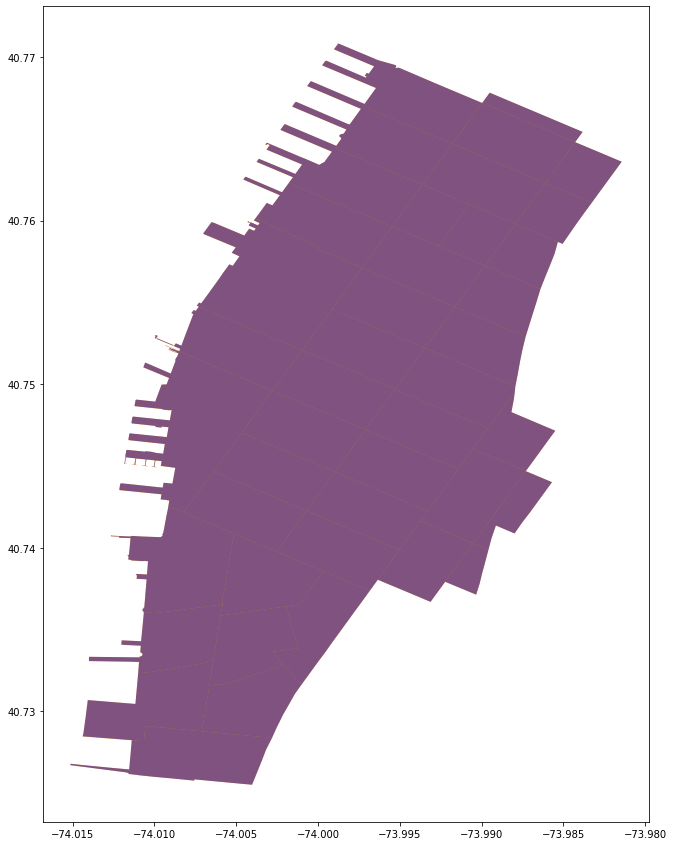

In [84]:
# plot geometries of districts (the_geom) from df and census tracts (geometry) from gdf on same plot
fig, ax = plt.subplots()
df = gpd.GeoDataFrame(df, geometry='the_geom')
gdf = gpd.GeoDataFrame(gdf, geometry='geometry')

# plot 
# gpd.GeoSeries(df['the_geom']).plot(ax=ax, color='orange')
# gpd.GeoSeries(gdf['geometry']).plot(ax=ax, color='blue', alpha=0.5)

# plot district 3 geometry from df and all census tracts from blocks_districts in which CounDist is 3
gpd.GeoSeries(df[df['CounDist'] == 3]['the_geom']).plot(ax=ax, color='orange')
gpd.GeoSeries(blocks_districts[blocks_districts['CounDist'] == 3]['geometry']).plot(ax=ax, color='blue', alpha=0.5)

# make it bigger
fig.set_size_inches(15, 15)

In [76]:
# for each row in blocks_in_districts
for index, row in blocks_districts.iterrows():
    # get block multipolygon
    block_multipolygon = row['geometry']

    # get district
    district = row['CounDist']

    # get district's multipolygon
    district_multipolygon = df[df['CounDist'] == district]['the_geom'].values[0]

    # determine the percent of the block area that is in the district multipolygon
    percent = block_multipolygon.intersection(district_multipolygon).area / block_multipolygon.area

    # add a new column to blocks_in_districts called percent that contains the percent of the block area that is in the district multipolygon
    blocks_districts.at[index, 'percent'] = percent

    # sort rows by percent from least to greatest
    blocks_districts = blocks_districts.sort_values(by='percent')

In [87]:
# remove rows where percent < 0.5
blocks_districts = blocks_districts[blocks_districts['percent'] >= 0.5]

In [88]:
# save as ny_blocks_districts.csv
blocks_districts.to_csv('ny_blocks_districts.csv', index=False)

In [80]:
# calculate how much of each district is composed of blocks with percent column of >0.5
# for each district
for i in range(1, 52):
    # get the district's multipolygon
    district_multipolygon = df[df['CounDist'] == i]['the_geom'].values[0]

    # get the blocks in blocks_districts that are in the district and have a percent column of >0.5
    blocks_in_district = blocks_districts[(blocks_districts['CounDist'] == i)]

    # calculate the percent of the district that is composed of these blocks
    percent = blocks_in_district['geometry'].area.sum() / district_multipolygon.area

    # print the percent
    print(f'District {i} is composed of {percent * 100:.3f}% blocks with a percent column of >0.5')

District 1 is composed of 99.871% blocks with a percent column of >0.5
District 2 is composed of 99.984% blocks with a percent column of >0.5
District 3 is composed of 99.941% blocks with a percent column of >0.5
District 4 is composed of 99.964% blocks with a percent column of >0.5
District 5 is composed of 99.887% blocks with a percent column of >0.5
District 6 is composed of 99.986% blocks with a percent column of >0.5
District 7 is composed of 99.995% blocks with a percent column of >0.5
District 8 is composed of 99.937% blocks with a percent column of >0.5
District 9 is composed of 99.992% blocks with a percent column of >0.5
District 10 is composed of 99.948% blocks with a percent column of >0.5
District 11 is composed of 99.994% blocks with a percent column of >0.5
District 12 is composed of 99.999% blocks with a percent column of >0.5
District 13 is composed of 99.919% blocks with a percent column of >0.5
District 14 is composed of 99.999% blocks with a percent column of >0.5
D

In [86]:
# create a df with the district and a list of TRACTCE20s that are in the district
districts_tracts = blocks_districts.groupby('CounDist')['CT2020'].apply(list).reset_index()

districts_tracts.head()

,CounDist,CT2020
0,1,"[000301, 004700, 000500, 003900, 031704, 00010..."
1,2,"[004900, 055500, 001002, 004300, 002400, 00700..."
2,3,"[010100, 007400, 007600, 009901, 013501, 00490..."
3,4,"[006200, 012602, 008601, 002800, 013400, 01460..."
4,5,"[014802, 015200, 023802, 014602, 014402, 01180..."


In [ ]:
# to csv
districts_tracts.to_csv('nyc_districts_tracts.csv', index=False)